In [1]:
import meds
import proplot as pplt
import numpy as np

In [2]:
%matplotlib inline

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model_star_and_gal_grid, nanmad

In [ ]:
import yaml
import os
from esutil.pbar import PBar
import pprint
import piff
import json
import joblib
import fitsio


def _run_file(fname, img, img_ext, wgt, wgt_ext, bkg, bkg_ext):
    pmod = piff.read(fname)
    
    _img = (
        fitsio.read(img, ext=img_ext)
        - fitsio.read(bkg, ext=bkg_ext)
    )
    _wgt = fitsio.read(wgt, ext=wgt_ext)
    
    any_bad_thresh = 5
    flag_bad_thresh = 2
    res = make_good_regions_for_piff_model_star_and_gal_grid(
        pmod, _img, _wgt, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False,
        flag_bad_thresh=flag_bad_thresh, any_bad_thresh=any_bad_thresh,
    )   
        
    return fname, res["flags"], np.mean(res["bad_msk"])


TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

results = {}

for tname in TNAMES:
    results[tname] = {}
    for band in BANDS:
        print("%s-%s" % (tname, band), flush=True)
        
        results[tname][band] = {}

        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (tname, band)
        ) as fp:
            yml = yaml.safe_load(fp.read())
            
        jobs = []
        for i, src in PBar(enumerate(yml["src_info"]), total=len(yml["src_info"])):
            jobs.append(joblib.delayed(_run_file)(
                src["piff_path"],
                src["image_path"],
                src["image_ext"],
                src["weight_path"],
                src["weight_ext"],
                src["bkg_path"],
                src["bkg_ext"],
            ))
            if False:
                _run_file(
                    src["piff_path"],
                    src["image_path"],
                    src["image_ext"],
                    src["weight_path"],
                    src["weight_ext"],
                    src["bkg_path"],
                    src["bkg_ext"],
                )

        with joblib.Parallel(n_jobs=2, backend="loky", verbose=100) as par:
            outputs = par(jobs)
            
        for fname, flags, bf in outputs:
            results[tname][band][os.path.basename(fname)] = {
                "no_box_frac": bf,
                "flags": flags,
                "bbox": b,
            }
            
        with open("data.json", "w") as fp:
            json.dump(results, fp)

In [ ]:
for fname, flags, b in outputs:
    if flags == 0:
        bf = 1.0 - ((b["xmax"] - b["xmin"])*(b["ymax"] - b["ymin"]))/(4096*2048)
    else:
        bf = 1.0

    results[tname][band][os.path.basename(fname)] = {
        "no_box_frac": bf,
        "flags": flags,
        "bbox": b,
    }

with open("data.json", "w") as fp:
    json.dump(results, fp)

In [ ]:
os.system("mkdir -p piff_plots_%s" % BAND)

for i, src in PBar(enumerate(yml["src_info"]), total=len(yml["src_info"])):
    pmod = piff.read(src["piff_path"])
    print(src["image_path"])
    res = make_good_regions_for_piff_model(pmod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=True)
    print("    " + pprint.pformat(src["piff_info"]))
    
    t_arr = res["t_arr"]
    t_mn = res["t_mn"]
    t_std = res["t_std"]
    flags = res["flags"]
    b = res["bbox"]
    
    msk = (~np.isfinite(t_arr)) | (np.abs(t_arr - t_mn) > 25 * t_std)

    if np.any(msk):

        msk = (~np.isfinite(t_arr)) | (np.abs(t_arr - t_mn) > 15 * t_std)
        fig, axs = pplt.subplots(nrows=1, ncols=2)
        axs[0].imshow(np.log10(t_arr/t_std), cmap="rocket", origin="lower")
        axs[0].grid(False)
        axs[0].set_title("T")

        axs[1].imshow(msk, cmap="rocket", origin="lower")
        axs[1].grid(False)
        axs[1].set_title("|T - <T>| > 15 sigma(T)")
        axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
        axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
        axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
        axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

        fig.savefig("piff_plots_%s/psf_%d.png" % (BAND, i))

In [ ]:
import meds

bands = ["g", "r", "i", "z"]
mfiles = []
for band in bands:
    mfiles.append(meds.MEDS("DES0221-0750_r5592p01_%s_pizza-cutter-slices.fits.fz" % band))

In [ ]:
# start_obj = 9008
# nrows = 16

# fig, axs = pplt.subplots(nrows=nrows, ncols=4)

# for row in range(nrows):
#     obj = start_obj + row
#     for col in range(4):
#         psf = mfiles[col].get_psf(obj, 0)
#         axs[row, col].imshow(np.arcsinh(psf/np.std(psf[20, :])), origin="lower", cmap="rocket")
#         axs[row, col].grid(False)

In [ ]:
psf = mfiles[1].get_psf(9008, 0)

fig, axs = pplt.subplots()
axs.imshow(psf)

In [ ]:
import fitsio
d = fitsio.read("DES0221-0750_r5592p01_%s_pizza-cutter-slices.fits.fz" % "r", ext="epochs_info")

In [ ]:
msk = d["id"] == 9008

In [ ]:
d[msk]

In [ ]:
ii = fitsio.read("DES0221-0750_r5592p01_%s_pizza-cutter-slices.fits.fz" % "r", ext="image_info")

In [ ]:
ii[d[msk]["image_id"]]["image_path"]

In [ ]:
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

In [ ]:
import piff

piffs = []
psf_imgs = []
piff_flags = []
einds = np.where(msk)[0]
for eind in einds:
    arr = d[eind:eind+1]
    image_id = arr["image_id"][0]
    fname = ii[image_id]["image_path"]
    src = None
    for i, _src in enumerate(yml["src_info"]):
        if _src["image_path"].endswith(fname.split("/")[1]):
            src = _src
            
    assert src is not None, fname.split("/")[1]
    print(fname, src["piff_path"])
    piffs.append(piff.read(src["piff_path"]))
    row = arr["psf_row_start"][0] + 13
    col = arr["psf_col_start"][0] + 13
    print(row, col, src["piff_info"])
    psf_imgs.append(piffs[-1].draw(x=col, y=row, GI_COLOR=0.61, chipnum=list(piffs[-1].wcs.keys())[0]).array)
    piff_flags.append(compute_piff_flags(
        piff_info=src["piff_info"],
        max_fwhm_cen=3.6, 
        min_nstar=25, 
        max_exp_T_mean_fac=4, 
        max_ccd_T_std_fac=0.3,
    ))

In [ ]:
piff_flags

In [ ]:
fig, axs = pplt.subplots(nrows=len(psf_imgs), ncols=1)

for i, ax in enumerate(axs):
    ax.imshow(psf_imgs[i])
    print(psf_imgs[i].sum())

In [ ]:
%matplotlib inline

In [3]:
m = meds.MEDS("DES0221-0750_r_des-pizza-slices-y6-test_meds-pizza-slices-range9005-9010.fits.fz")

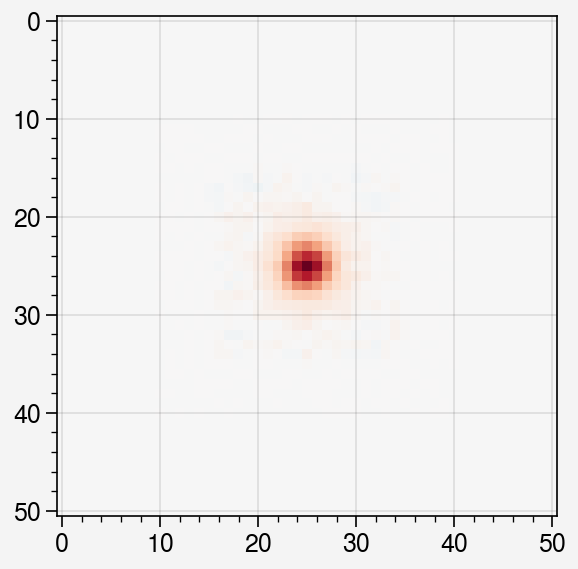

In [4]:
psf = m.get_psf(9008, 0)

fig, axs = pplt.subplots()
axs.imshow(psf)

In [5]:
import fitsio
ei = fitsio.read("DES0221-0750_r_des-pizza-slices-y6-test_meds-pizza-slices-range9005-9010.fits.fz", ext="epochs_info")

In [6]:
ei[ei["id"] == 9008]

array([(9008,  41,  0, 1206, 1599, 200, 1293, 1686, 25, 0.18500005),
       (9008,  66,  0, 2457, 1073, 200, 2544, 1160, 25, 0.23099706),
       (9008,  73,  0,  992, 1587, 200, 1079, 1674, 25, 0.13306306),
       (9008,  89,  0,  151, 1527, 200,  238, 1614, 25, 0.2363372 ),
       (9008, 152,  0, 2062, 1324, 200, 2149, 1411, 25, 0.21460263),
       (9008,  19, 32,  388,  728, 200,  475,  815, 25, 0.        ),
       (9008, 126, 32,  164,  596, 200,  251,  683, 25, 0.        )],
      dtype=[('id', '>i8'), ('image_id', '>i8'), ('flags', '>i4'), ('row_start', '>i8'), ('col_start', '>i8'), ('box_size', '>i8'), ('psf_row_start', '>i8'), ('psf_col_start', '>i8'), ('psf_box_size', '>i8'), ('weight', '>f8')])

In [ ]:
2**5